The merged crop yield and ASOS weather data are stored in dictionaries which have been pickled and saved with gzip (reduces file size by ~90%). They separated by state, and the dictionaries have the following format:

state dictionary
    key: county name
    value: data dictionary
        key: 'distance', 'yield', 'temp', or 'precip'
        value: 'distance' is # of km from the county center to the closest station
               'yield' is a dictionary  where the key is the year and value is the yield
               'temp' is a dictionary where key is the year and value is a list of tuples: (year, month, day, hour, temp)
               'precip' is a dictionary where key is the year and value is a list of tuples: (year, month, day, hour, precip)

We should limit our analysis to ar, ia, il, in, ks, mn, mo, nc, ne, oh, ok, sd, tn, tx, and wi - these have < 5% missing precip data, while most other states are > 50% missing.

In [11]:
import pickle
import gzip
import ag_utils

mergedCropWx = {}

with gzip.open('merged-crop-wx-ca.pgz', 'rb') as f:
    mergedCropWx = pickle.load(f)

In [12]:
# to get the list of counties...
mergedCropWx.keys()

dict_keys(['glenn', 'other (combined) counties', 'sacramento', 'solano', 'yolo', 'kern', 'merced', 'san joaquin', 'sutter', 'stanislaus', 'colusa', 'kings', 'tulare', 'butte', 'fresno', 'tehama', 'yuba', 'madera', 'san bernardino', 'contra costa', 'imperial', 'riverside', 'humboldt', 'placer', 'santa barbara', 'alameda', 'sonoma', 'siskiyou', 'san diego', 'san luis obispo', 'amador', 'shasta', 'san benito', 'monterey', 'santa clara', 'los angeles', 'ventura', 'san mateo', 'calaveras', 'lassen', 'modoc', 'lake', 'mendocino', 'el dorado', 'orange'])

In [13]:
# counties that were matched have data dictionaries 
print(mergedCropWx['sacramento'].keys())

# if no match, an empty dictionary
print(mergedCropWx['glenn'])

dict_keys(['distance', 'tempMissingPercentage', 'precipMissingPercentage', 'yield', 'year', 'month', 'day', 'hour', 'temp', 'precip'])
{}


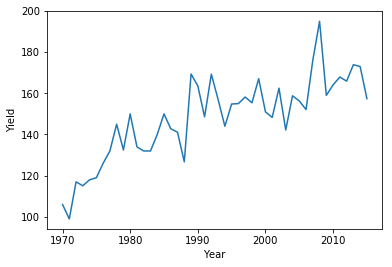

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# yield dictionary keys are years and values are annual yields
years = list(mergedCropWx['sacramento']['yield'].keys())
yields = list(mergedCropWx['sacramento']['yield'].values())

plt.plot(years, yields)
plt.xlabel('Year')
plt.ylabel('Yield')

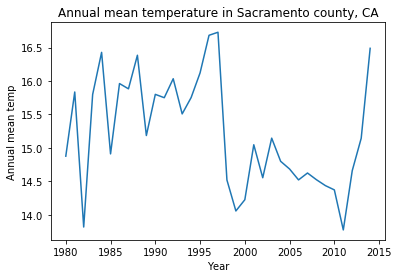

In [24]:
import numpy

# get all temps and associated year
years = numpy.array(mergedCropWx['sacramento']['year']).astype('float')
temps = numpy.array(mergedCropWx['sacramento']['temp']).astype('float')

annualMeanTemps = []

# loop over all years
uniqueYears = numpy.unique(years)
uniqueYears = uniqueYears[~numpy.isnan(uniqueYears)]

for y in uniqueYears:
    
    # find indices of this year
    ind = numpy.where(years == y)
    
    # take mean of all temps in that year
    annualMean = numpy.nanmean(temps[ind])
    annualMeanTemps.append(annualMean)


plt.plot(uniqueYears, annualMeanTemps)
plt.xlabel('Year')
plt.ylabel('Annual mean temp')
plt.title('Annual mean temperature in Sacramento county, CA')

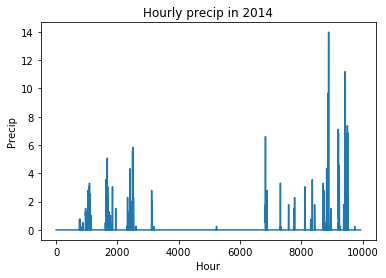

In [23]:
import numpy

# get all temps and associated year
years = numpy.array(mergedCropWx['sacramento']['year']).astype('float')
precip = numpy.array(mergedCropWx['sacramento']['precip']).astype('float')

ind = numpy.where(years == 2014)

plt.plot(precip[ind])
plt.xlabel('Hour')
plt.ylabel('Precip')
plt.title('Hourly precip in 2014')

In [30]:
# How many nans are there in each county's temp and precip records...

for county in mergedCropWx.keys():
    # if this county has a matched station
    if len(mergedCropWx[county]) > 0:
        tempNans = numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['temp'])))
        precipNans = numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['precip'])))

        # convert to percent
        tempNans = tempNans / float(numpy.size(mergedCropWx[county]['temp'])) * 100
        precipNans = precipNans / float(numpy.size(mergedCropWx[county]['precip'])) * 100

        print(county + ":", str(round(tempNans)) + '% temp nan, ' + str(round(precipNans)) + '% precip nan')

sacramento: 2% temp nan, 87% precip nan
solano: 0% temp nan, 75% precip nan
yolo: 2% temp nan, 21% precip nan
kern: 2% temp nan, 38% precip nan
merced: 3% temp nan, 84% precip nan
san joaquin: 2% temp nan, 87% precip nan
sutter: 2% temp nan, 86% precip nan
stanislaus: 1% temp nan, 87% precip nan
kings: 3% temp nan, 90% precip nan
tulare: 1% temp nan, 83% precip nan
butte: 1% temp nan, 75% precip nan
fresno: 2% temp nan, 89% precip nan
tehama: 2% temp nan, 85% precip nan
yuba: 1% temp nan, 75% precip nan
contra costa: 37% temp nan, 86% precip nan
imperial: 1% temp nan, 90% precip nan
riverside: 1% temp nan, 90% precip nan
humboldt: 0% temp nan, 10% precip nan
placer: 0% temp nan, 9% precip nan
santa barbara: 1% temp nan, 45% precip nan
alameda: 4% temp nan, 76% precip nan
sonoma: 3% temp nan, 83% precip nan
siskiyou: 3% temp nan, 88% precip nan
san diego: 0% temp nan, 77% precip nan
san luis obispo: 2% temp nan, 86% precip nan
amador: 0% temp nan, 40% precip nan
shasta: 3% temp nan, 85%

In [34]:
# and now look at nan counts across all states:

import glob

# find all compressed merged crop/wx files
files = glob.glob('*.pgz')

# loop over all files (states)
for file in files:
    
    # get current state abrev
    parts = file.split('-')
    parts = parts[-1].split('.')
    state = parts[0]
    
    mergedCropWx = {}
    
    # load current file and de-pickle
    with gzip.open(file, 'rb') as f:
        mergedCropWx = pickle.load(f)
    
    totalTempLen = 0
    totalPrecipLen = 0
    tempNans = 0
    precipNans = 0
    
    # loop over all counties
    for county in mergedCropWx.keys():
        
        # if this county has a matched station
        if len(mergedCropWx[county]) > 0:
            # count up nans for each county
            tempNans += numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['temp'])))
            precipNans += numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['precip'])))

            # and count up all days
            totalTempLen += float(numpy.size(mergedCropWx[county]['temp']))
            totalPrecipLen += float(numpy.size(mergedCropWx[county]['precip']))
    
    tempPercent = tempNans / totalTempLen * 100
    precipPercent = precipNans / totalPrecipLen * 100
    
    print(state + ':', str(round(tempPercent)) + '% temp nan, ' + str(round(precipPercent)) + '% precip nan')
    
    

al: 1% temp nan, 67% precip nan
ar: 2% temp nan, 2% precip nan
az: 2% temp nan, 85% precip nan
ca: 3% temp nan, 79% precip nan
co: 2% temp nan, 77% precip nan
de: 4% temp nan, 83% precip nan
fl: 1% temp nan, 77% precip nan
ga: 2% temp nan, 59% precip nan
ia: 1% temp nan, 1% precip nan
id: 3% temp nan, 83% precip nan
il: 1% temp nan, 1% precip nan
in: 2% temp nan, 3% precip nan
ks: 1% temp nan, 2% precip nan
ky: 4% temp nan, 72% precip nan
la: 2% temp nan, 69% precip nan
md: 2% temp nan, 73% precip nan
mi: 1% temp nan, 79% precip nan
mn: 1% temp nan, 1% precip nan
mo: 1% temp nan, 1% precip nan
ms: 1% temp nan, 72% precip nan
mt: 3% temp nan, 87% precip nan
nc: 1% temp nan, 1% precip nan
nd: 1% temp nan, 53% precip nan
ne: 0% temp nan, 1% precip nan
nj: 3% temp nan, 77% precip nan
nm: 4% temp nan, 84% precip nan
ny: 1% temp nan, 78% precip nan
oh: 1% temp nan, 1% precip nan
ok: 1% temp nan, 2% precip nan
or: 3% temp nan, 79% precip nan
pa: 2% temp nan, 78% precip nan
sc: 1% temp nan, 51